In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mylibrary.nnlib as tnn
import matplotlib

(200, 2) (200, 1)


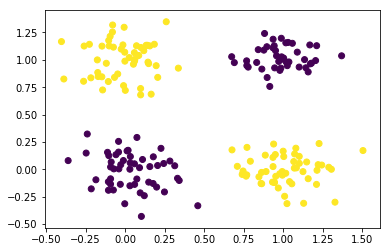

In [3]:
T = 1.
F = 0.

xxx = np.array([[F, F],
      [F, T],
      [T, F],
      [T, T],])
yyy = np.array([[F],[T],[T],[F]])

x = []
y = []
n_data = 200
for i in range(n_data):
    index = np.random.randint(low=0, high=4)
    xx = xxx[index] + np.random.normal(loc=0., scale=0.15, size=xxx[0].size)
    x.append(xx)
    y.append(yyy[index])
x, y = np.array(x), np.array(y)
print(x.shape, y.shape)
plt.scatter(x[:,0], x[:, 1], c=y.reshape(-1))

In [4]:
def inrange(X, break0, break1): #if x is after
    xmsk1 = X >= break0
    xmsk2 = X < break1
    xmsk = np.bitwise_and(xmsk1, xmsk2)
    xs = xmsk #*X
    return xs

In [5]:
def linear_interpolation(X, break_x, break_y):
    x,y = break_x, break_y
    n = len(break_x)
    Y = np.zeros_like(X)
    for i in range(n-1):
        mask = inrange(X, break_x[i], break_x[i+1])
        Y_ = (y[i+1] - y[i])/(x[i+1] - x[i])*(X - x[i]) + y[i]
        Y = Y + Y_*mask
    return Y

In [6]:
def backward(X, dY, break_x, break_y):
    x,y = break_x, break_y
    n = len(break_x)
    Y = np.zeros((n, X.shape[0]))
    inranges = np.zeros((n-1, X.shape[0]))
    consts = np.zeros_like(inranges)
    
    for i in range(n-1):
        inranges[i] = inrange(X, break_x[i], break_x[i+1])
            
    for i in range(n-1):
        consts[i] = ((X-x[i])/(x[i+1] - x[i]))
    
    Y[0] = (-1* consts[0] +1)*inranges[0]
    Y[-1] = consts[-1]*inranges[-1]
    for i in range(1, n-1):
            a = consts[i-1]*inranges[i-1]
            b = (-1* consts[i] +1)*inranges[i]
            Y[i] = a+b
    Y = Y*dY
    ny = np.count_nonzero(inranges, axis=1)
    Y = Y.mean(axis=1)
    return Y

In [7]:
def backward2(X, dY, break_x, break_y):
    x,y = break_x, break_y
    n = len(x)
    XX = np.zeros((n, X.shape[0]))
    inranges = np.zeros((n-1, X.shape[0]))
    consts = np.zeros_like(inranges)
    
    for i in range(n-1):
        inranges[i] = inrange(X, x[i], x[i+1])
            
    for i in range(n-1):
        consts[i] = ((y[i+1]-y[i])/(x[i+1] - x[i])**2)
    
    XX[0] = consts[0]*(X - x[1])*inranges[0]
    XX[-1] = -1*consts[-1]*(X - x[-2])*inranges[-1]
    for i in range(1, n-1):
            a = -1*consts[i-1]*(X - x[i-1])*inranges[i-1]
            b = consts[i]*(X - x[i+1])*inranges[i]
            XX[i] = a+b
    XX = XX*dY
#     nx = np.count_nonzero(inranges, axis=1)
    XX = XX.mean(axis=1)
    return XX

In [8]:
def backward3(X, dY, break_x, break_y):
    x,y = break_x, break_y
    n = len(break_x)
    Y = np.zeros_like(X)
    
    for i in range(n-1):
        Y = Y + (y[i+1] - y[i])/(x[i+1] - x[i])*inrange(X, break_x[i], break_x[i+1])
    
    Y = Y*dY
    return Y

In [9]:
def error_piecewise(X, dY, break_x, break_y):
    x,y = break_x, break_y
    n = len(x)
    XX = np.zeros((n, X.shape[0]))
    dYs = np.zeros((n-1, X.shape[0]))
    for i in range(n-1):
        dYs[i] = dY*inrange(X, x[i], x[i+1])
    dYerr = (dYs**2).mean(axis=1)
    return dYerr

In [10]:
colors = ['r', 'y', 'g', 'b']

In [12]:
optimizer = tnn.Adam(learning_rate=0.01)
logisti11 = tnn.NonLinearLayer(2, 1,activation=tnn.LeakyRelu(), optimizer=optimizer)
nlinear11 = tnn.NonLinearLayer(1, 3,activation=tnn.LeakyRelu(), optimizer=optimizer)
logisti12 = tnn.NonLinearLayer(3, 1,activation=tnn.Sigmoid(), optimizer=optimizer)
logistic1 = tnn.AutoForm()
logistic1.collect_global_layers()

%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.ion()
fig.show()
fig.canvas.draw()

for step in range(10000):
    a1 = logistic1.forward(x)
    loss = tnn.CrossEntropyBinary.loss(a1, y)
    dy = tnn.CrossEntropyBinary.del_loss(a1, y)
    
    dx = logistic1.backward(dy)
    logistic1.update()
    
    if step % 10 == 0:

        print('_______________________')
        print("epoch", step)
        print("Loss", loss)
        out = (a1>0.5).astype(int)

        ax.clear()
        plt.scatter(x[:,0], x[:, 1], c=y.reshape(-1), lw=5)
        plt.scatter(x[:,0], x[:, 1], c=out.reshape(-1), marker='+', cmap=matplotlib.colors.ListedColormap(colors))
        fig.canvas.draw()
        
        plt.pause(0.01)
        print("\n")
        if loss < 0.0025:
            print('fitted to our expectation')
            plt.pause(50)
            break

_______________________
epoch 0
Loss 0.6933240009623279


_______________________
epoch 10
Loss 0.6908404470288904


_______________________
epoch 20
Loss 0.68715820607513


_______________________
epoch 30
Loss 0.67896427530638


_______________________
epoch 40
Loss 0.6658137750806464


_______________________
epoch 50
Loss 0.6496699344576868


_______________________
epoch 60
Loss 0.6291988782930867


_______________________
epoch 70
Loss 0.6058659790875963


_______________________
epoch 80
Loss 0.5814826253374621


_______________________
epoch 90
Loss 0.5582984524541442


_______________________
epoch 100
Loss 0.5381936524655125


_______________________
epoch 110
Loss 0.5217911927081024


_______________________
epoch 120
Loss 0.5086071741935727


_______________________
epoch 130
Loss 0.4978790319506418


_______________________
epoch 140
Loss 0.4887270573751393


_______________________
epoch 150
Loss 0.48053070922803975


_______________________
epoch 160
Loss 0.4729284608090

TclError: this isn't a Tk application

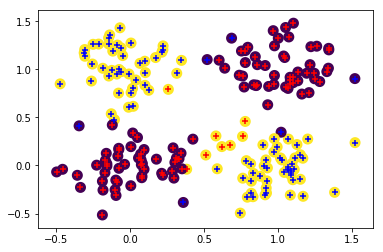

In [85]:
%matplotlib inline
plt.scatter(x[:,0], x[:, 1], c=y.reshape(-1), lw=5)
plt.scatter(x[:,0], x[:, 1], c=out.reshape(-1), marker='+', cmap=matplotlib.colors.ListedColormap(colors))

### XOR gate with spline regression

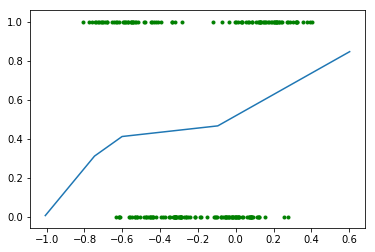

In [98]:
lr=0.1
linear = tnn.LinearLayer(2,1, optimizer=tnn.SGD(lr))
x_ = linear.forward(x)

n_breaks = 5
parmx = list(np.sort(np.random.uniform(x_.min(), x_.max(), size=(n_breaks-2))))
parmx = np.array([x_.min()-0.2]+parmx+[x_.max()+0.2])
parmy = np.sort(np.random.uniform(y.min(), y.max(), size=(n_breaks)))

%matplotlib inline
plt.scatter(x_, y, marker='.', color='g')
plt.plot(parmx, parmy)

array([[ 0.17108897],
       [-0.55542213]])

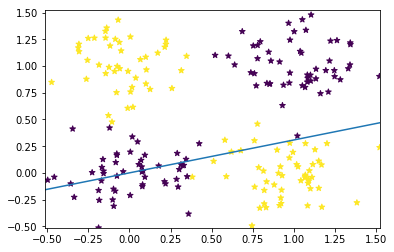

In [99]:
wr, br = linear.weights, linear.bias
x0pt = np.array([x.min(), x.max()])
x1pt = -(x0pt * wr[0][0] + br)/wr[1][0]

plt.scatter(x[:,0], x[:, 1], c=y.reshape(-1), marker='*')
plt.plot(x0pt, x1pt)
plt.xlim(x.min(), x.max())
plt.ylim(x.min(), x.max())
wr

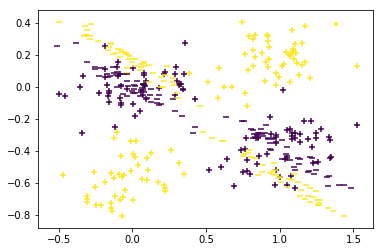

In [100]:
plt.scatter(x[:,0], x_, marker='+',c=y.reshape(-1))
plt.scatter(x[:,1], x_, marker='_',c=y.reshape(-1))

_______________________
Steps 0
Error 0.0587121242483591
parmx (5,)


_______________________
Steps 10
Error 0.05688322593929251
parmx (5,)


_______________________
Steps 20
Error 0.0563005585721522
parmx (5,)


_______________________
Steps 30
Error 0.056274879302193596
parmx (5,)


_______________________
Steps 40
Error 0.056225484911909845
parmx (5,)


_______________________
Steps 50
Error 0.056196253912925244
parmx (5,)


_______________________
Steps 60
Error 0.056293343788346696
parmx (5,)


_______________________
Steps 70
Error 0.058856374622937274
parmx (5,)


_______________________
Steps 80
Error 0.05870293691364999
parmx (5,)


_______________________
Steps 90
Error 0.05901414481121769
parmx (5,)


_______________________
Steps 100
Error 0.05850287255222615
parmx (5,)


_______________________
Steps 110
Error 0.05707180368694635
parmx (5,)


_______________________
Steps 120
Error 0.05633438785218076
parmx (5,)


_______________________
Steps 130
Error 0.05624244294082004



_______________________
Steps 1120
Error 0.05600972780867334
parmx (5,)


_______________________
Steps 1130
Error 0.05600249751564269
parmx (5,)


_______________________
Steps 1140
Error 0.055985562908507536
parmx (5,)


_______________________
Steps 1150
Error 0.05826303849823434
parmx (5,)


_______________________
Steps 1160
Error 0.05947531311031758
parmx (5,)


_______________________
Steps 1170
Error 0.05907971881218343
parmx (5,)


_______________________
Steps 1180
Error 0.057956458366510887
parmx (5,)


_______________________
Steps 1190
Error 0.056422209087477346
parmx (5,)


_______________________
Steps 1200
Error 0.056039719328934624
parmx (5,)


_______________________
Steps 1210
Error 0.0559962110375011
parmx (5,)


_______________________
Steps 1220
Error 0.055990239035410685
parmx (5,)


_______________________
Steps 1230
Error 0.055965508024641064
parmx (5,)


_______________________
Steps 1240
Error 0.05695037474748386
parmx (5,)


_______________________
Steps 1

TclError: this isn't a Tk application

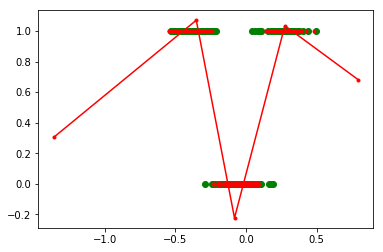

In [104]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()
y_ = y.reshape(-1)
for step in range(10000):
    x_ = linear.forward(x).reshape(-1)
    Y = linear_interpolation(x_, parmx, parmy)
    dy = Y-y_
    dparmy = backward(x_, dy, parmx, parmy)
    dparmx = backward2(x_, dy, parmx, parmy)
    dx_ = backward3(x_, dy, parmx, parmy)
    dx = linear.backward(dx_.reshape(-1,1)).reshape(-1)
    
    parmy = parmy - dparmy * lr # update
    parmx = parmx - dparmx * lr
    linear.update()
    
    # sorting the points for everything :D
    sortindx = np.argsort(parmx)
    parmx = parmx[sortindx]
    parmy = parmy[sortindx]
    
    if step % 100 == 0:
        # postprocessing the splines
        # removing ones which are very close to each other
        parmx_grad = np.gradient(parmx)
        clipmask = np.abs(parmx_grad) > 1e-2
        parmx = parmx[clipmask]
        parmy = parmy[clipmask]
        
        # removing the ones which are on same line
        triangle = np.ones_like(parmx)
        for i in range(len(parmx)-2):
            triangle[i+1] = 0.5*np.abs(
                (parmx[i] - parmx[i+2])*(parmy[i+1] - parmy[i])-
                (parmx[i] - parmx[i+1])*(parmy[i+2] - parmy[i]))
        mergemask = triangle > 1e-2
        parmx = parmx[mergemask]
        parmy = parmy[mergemask]
        
        # adding units where the 
#         for _ in range(len(parmx), n_breaks):
        if len(parmx)< n_breaks:
            Y = linear_interpolation(x_, parmx, parmy)
            dyerr = error_piecewise(x_, Y-y_, parmx, parmy)
            index = np.argmax(dyerr)
            newpx = (parmx[index] + parmx[index+1])/2.
            newpy = (parmy[index] + parmy[index+1])/2.
            # adding new interpolation points
            parmx = np.append(parmx, newpx)
            parmy = np.append(parmy, newpy)
            # sorting the points for plotting
            sortindx = np.argsort(parmx)
            parmx = parmx[sortindx]
            parmy = parmy[sortindx]
        
        
    if step % 10 == 0:
            
        error = (dy**2).mean()
        
        print('_______________________')
        print("Steps", step)
        print("Error", error)
        print("parmx", parmx.shape)
        
        
        ax.clear()
        plt.scatter(x_, y, marker='o', color='g')
        plt.plot(parmx, parmy, marker='.', color='r')
        x_ = linear.forward(x).reshape(-1)
        Y = linear_interpolation(x_, parmx, parmy)
        out = (Y>0.5).astype(int)
        plt.scatter(x_, out, marker='.', color='r')
        

        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            plt.pause(50)
            break

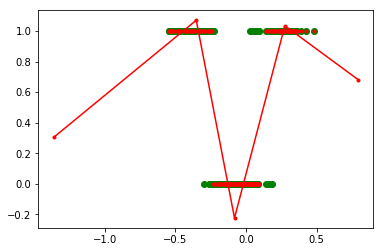

In [105]:
%matplotlib inline

plt.scatter(x_, y, marker='o', color='g')
plt.plot(parmx, parmy, marker='.', color='r')
x_ = linear.forward(x).reshape(-1)
Y = linear_interpolation(x_, parmx, parmy)
out = (Y>0.5).astype(int)
plt.scatter(x_, out, marker='.', color='r')

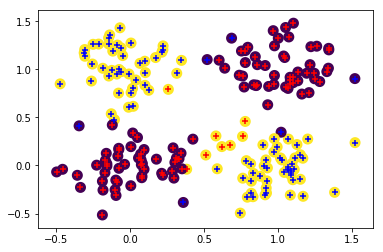

In [106]:
%matplotlib inline
plt.scatter(x[:,0], x[:, 1], c=y.reshape(-1), lw=5)
plt.scatter(x[:,0], x[:, 1], c=out.reshape(-1), marker='+', cmap=matplotlib.colors.ListedColormap(colors))